In [8]:
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langgraph.graph import START, END, StateGraph

In [24]:
class GraphState(TypedDict, total=False):
    user_id: str
    otp_input: str
    otp_valid: bool
    awaiting_otp: bool
    intent: str
    question: str
    answer: str

In [25]:
@tool
def router_node(state: GraphState) -> GraphState:
    """
    Decide la intención del usuario. Simulación por ahora.
    """
    question = state.get("question", "").lower()
    
    if "vacaciones" in question:
        return {"intent": "vacaciones"}
    elif "liquidacion" in question:
        return {"intent": "liquidacion"}
    elif "permiso" in question:
        return {"intent": "permiso"}
    elif "certificado" in question:
        return {"intent": "certificado"}
    elif "ausencia" in question:
        return {"intent": "ausencias"}
    elif "dias trabajados" in question:
        return {"intent": "dias_trabajados"}
    else:
        return {"intent": "faq"}

In [40]:
@tool
def otp_node(state: GraphState) -> GraphState:
    """
    Recupera documentos relevantes desde el índice FAISS en base a la pregunta del usuario.
    """
    if state.get("otp_input", "") == "":
        print("🔐 Enviando OTP...")
        return {"awaiting_otp": True, "otp_valid": False}
    
    if state["otp_input"] == "123456":
        print("✅ OTP correcto.")
        return {"otp_valid": True, "awaiting_otp": False}
    
    print("❌ OTP incorrecto.")
    return {"otp_valid": False, "awaiting_otp": False}

In [41]:
@tool
def faq_pdf_node(state: GraphState) -> GraphState:
    """
    Recupera documentos relevantes desde el índice FAISS en base a la pregunta del usuario.
    """
    return {"answer": "Respuesta desde el PDF."}

In [42]:
@tool
def liquidacion_node(state: GraphState) -> GraphState:
    """
    Recupera documentos relevantes desde el índice FAISS en base a la pregunta del usuario.
    """
    return {"answer": "Aquí tienes tu liquidación 💵"}


In [43]:
@tool
def permiso_node(state: GraphState) -> GraphState:
    """
    Recupera documentos relevantes desde el índice FAISS en base a la pregunta del usuario.
    """
    return {"answer": "Tu permiso ha sido creado y enviado para firma ✍️"}

@tool
def vacaciones_node(state: GraphState) -> GraphState:
    """
    Recupera documentos relevantes desde el índice FAISS en base a la pregunta del usuario.
    """
    return {"answer": "Tu solicitud de vacaciones ha sido registrada 🏖️"}

@tool
def dias_trabajados_node(state: GraphState) -> GraphState:
    """
    Recupera documentos relevantes desde el índice FAISS en base a la pregunta del usuario.
    """
    return {"answer": "Has trabajado 22 días este mes 📅"}

@tool
def ausencias_node(state: GraphState) -> GraphState:
    """
    Recupera documentos relevantes desde el índice FAISS en base a la pregunta del usuario.
    """
    return {"answer": "Tienes 3 días de ausencia registrados 😕"}

@tool
def certificado_node(state: GraphState) -> GraphState:
    """
    Recupera documentos relevantes desde el índice FAISS en base a la pregunta del usuario.
    """
    return {"answer": "Aquí está tu certificado de antigüedad 📄"}

@tool
def saludo_node(state: GraphState) -> GraphState:
    """
    Recupera documentos relevantes desde el índice FAISS en base a la pregunta del usuario.
    """
    return {
        "answer": "👋 ¡Hola! Soy la asistente virtual de Recursos Humanos. ¿En qué puedo ayudarte?\n\nPuedes pedirme tu liquidación, pedir vacaciones, generar un certificado o consultar ausencias."
    }



In [44]:
graph = StateGraph(GraphState)

# Agregar nodos

graph.add_node("router", router_node)
graph.add_node("otp", otp_node)
graph.add_node("faq_pdf", faq_pdf_node)
graph.add_node("liquidacion", liquidacion_node)
graph.add_node("permiso", permiso_node)
graph.add_node("vacaciones", vacaciones_node)
graph.add_node("dias_trabajados", dias_trabajados_node)
graph.add_node("ausencias", ausencias_node)
graph.add_node("certificado", certificado_node)


graph.add_node("saludo", saludo_node)
graph.set_finish_point("saludo")



In [45]:
graph.set_entry_point("router")


In [46]:
graph.add_conditional_edges(
    "router",
    lambda state: (
        "faq_pdf" if state.get("intent") == "faq" else
        "saludo" if state.get("intent") == "saludo" else
        "otp"
    ),
    {
        "faq_pdf": "faq_pdf",
        "saludo": "saludo",
        "otp": "otp"
    }
)



In [47]:
graph.add_conditional_edges(
    "otp",
    lambda state: (
        "awaiting_otp" if state.get("awaiting_otp") else (
            "valid" if state.get("otp_valid") else "invalid"
        )
    ),
    {
        "awaiting_otp": "otp",
        "invalid": "otp",
        "valid": "flujo_sensible"
    }
)


In [48]:
@tool
def flujo_sensible_node(state: GraphState) -> GraphState:
    """
    Recupera documentos relevantes desde el índice FAISS en base a la pregunta del usuario.
    """
    return state  # Passthrough: no modifica, solo dirige


In [49]:
graph.add_node("flujo_sensible", flujo_sensible_node)


In [50]:
graph.add_conditional_edges(
    "flujo_sensible",
    lambda state: state["intent"],
    {
        "liquidacion": "liquidacion",
        "permiso": "permiso",
        "vacaciones": "vacaciones",
        "dias_trabajados": "dias_trabajados",
        "ausencias": "ausencias",
        "certificado": "certificado"
    }
)



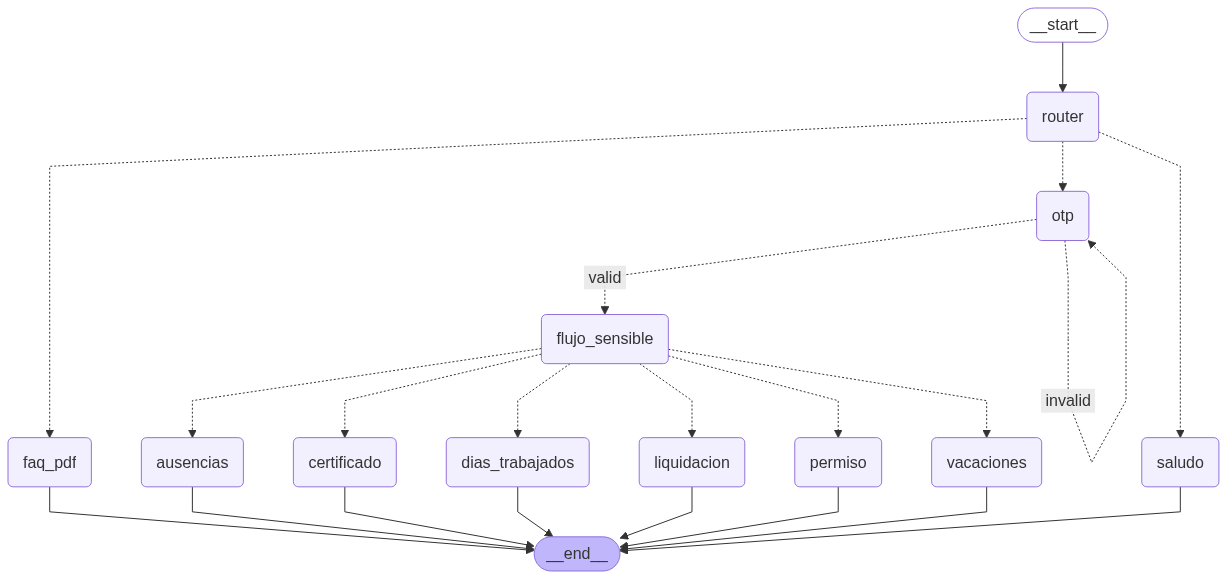

In [51]:
from IPython.display import Image, display

graph.set_finish_point("liquidacion")
graph.set_finish_point("permiso")
graph.set_finish_point("vacaciones")
graph.set_finish_point("dias_trabajados")
graph.set_finish_point("ausencias")
graph.set_finish_point("certificado")
graph.set_finish_point("faq_pdf")

main_graph = graph.compile()
display(Image(main_graph.get_graph().draw_mermaid_png()))


In [23]:
state = {
    "user_id": "usuario123",
    "question": "quiero ver mi liquidacion",
    "otp_input": "123456"
}

result = main_graph.invoke(state)
print("✅ Respuesta:", result.get("answer"))


ValidationError: 1 validation error for router_node
state
  Field required [type=missing, input_value={'user_id': 'usuario123',...ero ver mi liquidacion'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing